# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [92]:
# Run some setup code for this notebook.
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [93]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


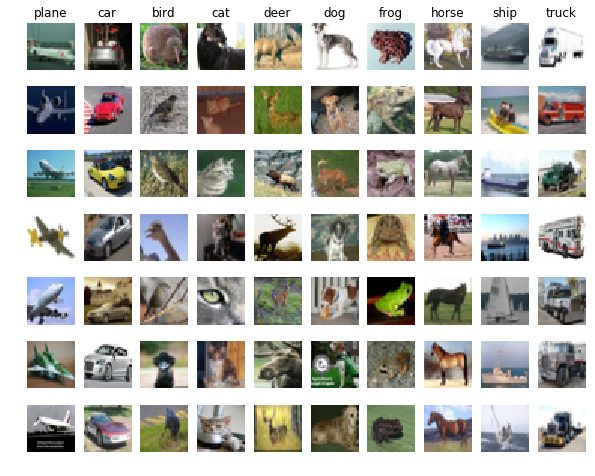

In [94]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [95]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
# print("y_dev: ", y_dev)


Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [96]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


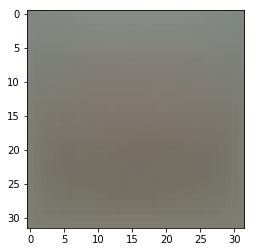

In [97]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [98]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [99]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [100]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
print('grad: ', grad)

loss: 8.662350
grad:  [[-2.08391477e+01  5.67359355e+00 -1.20549866e+01 ...  2.73116204e+00
  -2.18078782e+01 -2.41302310e+01]
 [-3.08428129e+01  4.76114163e+00 -6.76974428e+00 ...  6.91636531e+00
  -3.07484018e+01 -3.10922373e+01]
 [-5.19610166e+01  2.11048604e+00  9.49365141e-01 ...  6.41252163e+00
  -4.28035738e+01 -4.16556272e+01]
 ...
 [-8.55258285e-01  8.34174302e+00 -4.37806743e+00 ... -2.05912392e+01
   5.17696310e+00 -1.03495636e+01]
 [-1.69904660e+01  6.45927371e+00 -1.96159400e+00 ... -5.07599143e+00
  -1.43112094e+01 -9.04431171e+00]
 [-1.54000001e-01  1.72000000e-01  1.40000008e-02 ...  1.99999990e-02
  -2.20000003e-02  2.06000000e-01]]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [101]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -16.791013 analytic: -16.714213, relative error: 2.292171e-03
numerical: -16.476489 analytic: -16.476489, relative error: 2.597300e-11
numerical: -13.347624 analytic: -13.347624, relative error: 1.551295e-11
numerical: 13.615481 analytic: 13.615481, relative error: 1.761258e-11
numerical: 8.749800 analytic: 8.749800, relative error: 2.914408e-12
numerical: -2.266806 analytic: -2.266806, relative error: 1.192123e-10
numerical: 10.763003 analytic: 10.759280, relative error: 1.729874e-04
numerical: -34.646814 analytic: -34.646814, relative error: 2.299581e-12
numerical: 31.172796 analytic: 31.172796, relative error: 1.079566e-12
numerical: -13.034701 analytic: -13.034701, relative error: 8.864817e-12
numerical: -13.423657 analytic: -13.345758, relative error: 2.909990e-03
numerical: -17.294332 analytic: -17.203240, relative error: 2.640544e-03
numerical: 9.722566 analytic: 9.638374, relative error: 4.348571e-03
numerical: 14.596127 analytic: 14.596127, relative error: 9.133809e

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:**
在梯度检查（gradcheck）中，某些维度的梯度可能会偶尔不完全匹配。这种不匹配可能是由以下原因导致的：

1. **不可微分点**：
   - SVM 损失函数中的 hinge 损失项在某些边界（例如 \( \text{margin} = 0 \)）处是不可微分的。在这些不可微分点，梯度计算可能会出现不匹配。具体来说，SVM 损失函数在样本点正好位于决策边界时会发生这种情况。

2. **数值误差**：
   - 梯度检查通常使用数值方法（如有限差分法）来近似梯度。由于计算机在进行数值计算时存在精度限制，特别是在处理非常小的差值时，可能会导致数值梯度与解析梯度之间存在轻微差异。

**是否需要担心**

- **小的误差**：如果梯度检查中的误差非常小（例如在 \(10^{-7}\) 的范围内），通常不需要太过担心，因为这种误差可能仅仅是由于数值精度引起的。
- **大的误差**：如果误差较大，则可能表明实现中存在问题。这时应当进一步检查梯度计算和损失函数的实现，以确保它们的正确性。

**一维情况下梯度检查失败的简单例子**

考虑一个简单的一维函数，例如绝对值函数：
\[ f(x) = |x| \]

这个函数在 \( x = 0 \) 处不可微分。梯度在 \( x > 0 \) 时为 1，在 \( x < 0 \) 时为 -1，但在 \( x = 0 \) 处梯度是未定义的。如果我们在 \( x = 0 \) 处进行梯度检查，数值梯度可能会与实际梯度不匹配，因为数值方法无法精确处理不可微分点。这就是一个典型的例子，说明在不可微分点处梯度检查可能会失败。

In [102]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.662350e+00 computed in 0.046903s
Vectorized loss: 8.594583e+00 computed in 0.003415s
difference: 0.067768


In [103]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.054348s
Vectorized loss and gradient: computed in 0.002371s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [104]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 771.779595
iteration 100 / 1500: loss 282.310434
iteration 200 / 1500: loss 103.769051
iteration 300 / 1500: loss 39.013813
iteration 400 / 1500: loss 16.447225
iteration 500 / 1500: loss 6.104511
iteration 600 / 1500: loss 4.767027
iteration 700 / 1500: loss 3.393575
iteration 800 / 1500: loss 2.900079
iteration 900 / 1500: loss 2.824779
iteration 1000 / 1500: loss 1.879798
iteration 1100 / 1500: loss 3.144646
iteration 1200 / 1500: loss 2.926539
iteration 1300 / 1500: loss 1.665202
iteration 1400 / 1500: loss 1.900475
That took 2.274341s


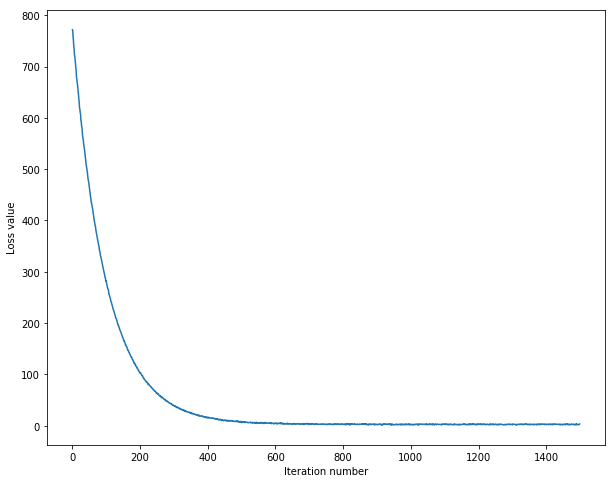

In [105]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [106]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.365245
validation accuracy: 0.368000


In [107]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
import itertools

# 使用 itertools.product 生成所有参数组合
param_combinations = list(itertools.product(learning_rates, regularization_strengths))
for combo in param_combinations:
    print(combo)

    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=combo[0], reg=combo[1],
                        num_iters=3000, verbose=True)     # iters = 1500
    # plt.plot(loss_hist)
    # plt.xlabel('Iteration number')
    # plt.ylabel('Loss value')
    # plt.show()
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % (train_accuracy, ))
    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % (val_accuracy, ))
    
    results[combo] = (train_accuracy, val_accuracy)
    if best_val <= val_accuracy:
        best_val = val_accuracy
        best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(1e-07, 25000.0)
iteration 0 / 3000: loss 783.063517
iteration 100 / 3000: loss 281.649547
iteration 200 / 3000: loss 103.667320
iteration 300 / 3000: loss 40.363012
iteration 400 / 3000: loss 16.106998
iteration 500 / 3000: loss 7.212502
iteration 600 / 3000: loss 4.148583
iteration 700 / 3000: loss 2.570921
iteration 800 / 3000: loss 3.578564
iteration 900 / 3000: loss 3.124221
iteration 1000 / 3000: loss 3.136299
iteration 1100 / 3000: loss 3.477510
iteration 1200 / 3000: loss 2.852918
iteration 1300 / 3000: loss 2.925931
iteration 1400 / 3000: loss 3.491346
iteration 1500 / 3000: loss 3.146099
iteration 1600 / 3000: loss 3.186367
iteration 1700 / 3000: loss 3.702985
iteration 1800 / 3000: loss 2.017738
iteration 1900 / 3000: loss 2.742476
iteration 2000 / 3000: loss 2.543938
iteration 2100 / 3000: loss 2.463900
iteration 2200 / 3000: loss 3.172256
iteration 2300 / 3000: loss 2.103058
iteration 2400 / 3000: loss 2.875547
iteration 2500 / 3000: loss 3.576017
iteration 2600 / 3000: lo

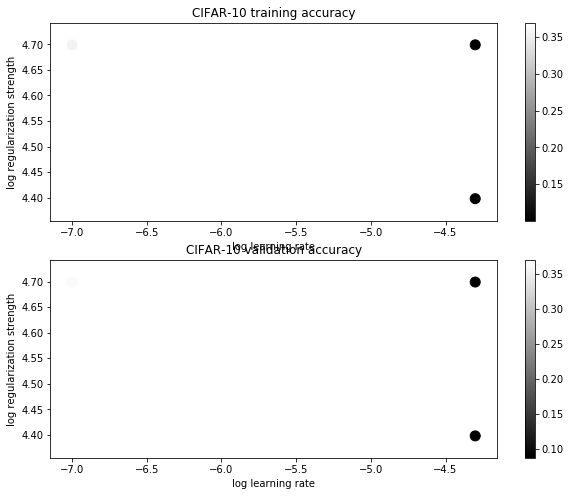

In [108]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [109]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.365000


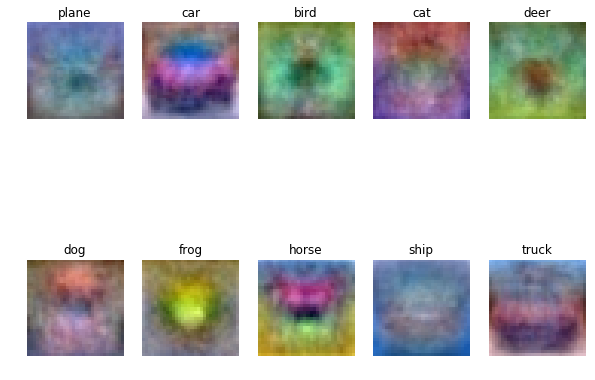

In [110]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 

- 描述可视化的 SVM 权重:

可视化的 SVM 权重图像显得模糊不清，其中只有一些类别，比如汽车（car）、马（horse）、卡车（truck）和青蛙（frog）的大致轮廓可以辨认出来，而其他类别则基本无法看清，图像显得非常模糊。

- 解释:

权重图像的模糊性可能是由于 SVM 模型在区分类别时所采用的方法造成的。每个类别的权重向量代表一个线性分类器，模型试图找到一个最佳超平面，将该类别与其他类别分开。

由于这是一个线性分类器，它在捕捉复杂模式方面存在局限性，尤其是在区分视觉上相似的物体或具有复杂特征的物体时。那些可识别的图像（如汽车、马、卡车和青蛙）可能具有更加明显和简单的特征，使得线性模型可以有效地分离，而其他类别可能过于复杂或与其他类别过于相似，导致权重可视化时呈现出模糊的效果。

此外，图像的质量还可能受到学习率和正则化强度等超参数选择的影响，这些参数决定了模型在训练数据上的泛化能力。如果这些参数选择不当，模型可能无法有效捕捉重要的特征，从而导致权重可视化图像模糊或不清晰。